In [1]:
ENV["GKS_ENCODING"] = "utf-8"
using NLsolve
using Plots
using BenchmarkTools
using Distributed
using IntervalArithmetic, IntervalRootFinding

include("/home/julian/Hamburg/LadderDGA/run.jl");

using 8 workers.
      From worker 6:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`


 Activating environment at `~/Hamburg/LadderDGA/Project.toml`


      From worker 4:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 3:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 2:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 7:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 8:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 5:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`


┌ Warning: ArgParse not working with jupyter notebooks
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/DepsInit.jl:48
┌ Warning: Check U and Beta consistency in chi_dir/gamma_dir
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/DepsInit.jl:49
┌ Info: Reading Inputs...
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/DepsInit.jl:51
┌ Info: Reading Fortran Input, this can take several minutes.
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/IO.jl:95
┌ Info: Done Reading Gamma
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/IO.jl:109
┌ Info: Done Reading chi
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/IO.jl:111
┌ Info: loading from 
│   env.inputVars = vars.jld
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/helpers.jl:62
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/helpers.jl:72
┌ Info: Inputs Read. Starting Computation.
│ Found usable intervals for local 

[ Info: Done.


In [2]:
modelParams, simParams, env, impQ_sp, impQ_ch, GImp_pos, Σ_loc_pos, FUpDo  = LadderDGA.setup_LDGA("config.toml", false);
mP = LadderDGA.modelParams;
sP = LadderDGA.simParams;
qMultiplicity = LadderDGA.qMultiplicity;
function subtract_tail(inp, Ekin, mP)
    res = zeros(eltype(inp), size(inp)...)
    iωₙ2_full  = zeros(length(inp))
    for i in 1:length(inp)
        iωₙ2_full[i] = (LadderDGA.iω(i - ceil(Int64, length(inp)/2) - 0))^2
    end
    for n in 1:length(inp)
        if iωₙ2_full[n] != 0
            res[n] = inp[n] - (Ekin/iωₙ2_full[n])
        else
            res[n] = inp[n]
        end
    end
    return res
end

function subtract_tail!(inp, Ekin, mP)
    iωₙ2_full  = zeros(length(inp))
    for i in 1:length(inp)
        iωₙ2_full[i] = (LadderDGA.iω(i - ceil(Int64, length(inp)/2) - 0))^2
    end
    for n in 1:length(inp)
        if iωₙ2_full[n] != 0
            inp[n] -= (Ekin/iωₙ2_full[n])
        end
    end
end

[ Info: Reading Fortran Input, this can take several minutes.
[ Info: Done Reading Gamma
[ Info: Done Reading chi
┌ Info: loading from 
└   env.inputVars = "vars.jld"
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ Main.LadderDGA ~/Hamburg/LadderDGA/src/helpers.jl:72


subtract_tail! (generic function with 1 method)

In [3]:
tc = true
usable_ω = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω);
rχsp = real.(nlQ_sp.χ[usable_ω,:]);
rχch = real.(nlQ_ch.χ[usable_ω,:]);
rhs_val = tc ? (mP.n / 2) * (1 - mP.n/2) : real(impQ_sp.χ_loc + impQ_ch.χ_loc)

χ_λ(χ, λ) = map(χi -> 1.0 / ((1.0 / χi) + λ), χ)
nc = [0,1,2,3]
NW = floor(Int64, size(rχch, 1)/2)
ωmin = 1#Int(floor(NW*1/4))
ωmax = NW 
W = LadderDGA.build_weights(ωmin, ωmax, [0,1,2,3])

iνₙ, GImp_pos    = LadderDGA.readGImp(LadderDGA.env.inputDir * "/gm_wim", only_positive=true)
ϵₖ, Vₖ, μ    = LadderDGA.read_anderson_parameters(LadderDGA.env.inputDir * "/hubb.andpar");
E_kin_ED, E_pot_ED  = LadderDGA.calc_E_ED(iνₙ[1:5000], ϵₖ, Vₖ, GImp_pos[1:5000], mP)
rem_full = -E_kin_ED*(mP.β*mP.β)/12

function construct_f!(F, λ, rhs)#default rhs χLocsp + χLocch or n/2 (1-n/2)
    χsp_λ = χ_λ(rχ_sp, λ[1])
    χch_λ = χ_λ(rχ_ch, λ[2]) 
    χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, qMultiplicity, dims=2)[:,1]
    #, [1], tc, mP.β, weights=W)[1]  
    tmp =  (sum(subtract_tail(χupup, E_kin_ED, mP))+rem_full)/mP.β        
    F[1] = real(tmp - rhs)
end


function construct_f(λsp, λch, χsp, χch; mode=:naive, rhs=rhs_val) 
    χsp_λ = LadderDGA.χ_λ(χsp, λsp)
    χch_λ = LadderDGA.χ_λ(χch, λch)
    χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1]  ./ 2
    nwh = ceil(Int64, size(χsp,1)/2)
    tmp = 0.0 - sum(χsp_λ[nwh,(χsp_λ[nwh,:] .< 0)]) - sum(χch_λ[nwh,(χch_λ[nwh,:] .< 0)])
    #println("penalty = $tmp")
    #println("eval λsp = $λsp, λch = $λch")
    if mode == :naive
        tmp += real(sum(χupup)/mP.β - rhs)
    elseif mode == :sub
        tmp +=  real((sum(subtract_tail(χupup, E_kin_ED, mP)) + rem_full)/mP.β - rhs)
    elseif mode == :fit
        tmp +=  real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=W)[1] - rhs)        
    else
        tmp +=  real(LadderDGA.sum_freq(subtract_tail(χupup, E_kin_ED, mP), [1], true, mP.β, correction=rem_full, weights=W)[1]- rhs)
    end 
    return tmp
end

function construct_df(λsp, λch, χsp, χch; mode=:naive, rhs=rhs_val) 
    χsp_λ = LadderDGA.dχ_λ(χsp, λsp)
    χch_λ = LadderDGA.dχ_λ(χch, λch)
    χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
    tmp = 0.0
    if mode == :naive
        tmp += real(sum(χupup)/mP.β)
    elseif mode == :sub
        tmp +=  real((sum(subtract_tail(χupup, E_kin_ED, mP)) + rem_full)/mP.β)
    elseif mode == :fit
        tmp +=  real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=W)[1])        
    else
        tmp +=  real(LadderDGA.sum_freq(subtract_tail(χupup, E_kin_ED, mP), [1], true, mP.β, correction=rem_full, weights=W)[1])
    end 
    return tmp
end

construct_df (generic function with 1 method)

# Condition 1

## compute λsp(λch) (NLsolve)

In [4]:
tc = sP.tail_corrected
nh = ceil(Int64, size(rχsp,1)/2)
χsp_min    = -minimum(1 ./ rχsp[nh,:])
χch_min    = -minimum(1 ./ rχch[nh,:])
extra_ch = 0.1
λch_range = (χch_min-extra_ch):0.01:3.0
spOfch_max_nl = zeros(2,size(λch_range)...)
for (mi,m) in enumerate([:naive, :fit])
    println("\rmode: ", m)
    rhs_val = tc ? (mP.n/2) * (1 - mP.n/2) : real(impQ_sp.χ_loc + impQ_ch.χ_loc)
    for (λi,λchi) in enumerate(λch_range)
        testf!(λ) = construct_f(λ[1],λchi, rχsp, rχch, mode=m, rhs=rhs_val)
        testdf!(λ) = construct_df(λ[1], λchi, rχsp, rχch, mode=m, rhs=rhs_val);
        spOfch_max_nl[mi,λi] = try
            nlsolve(testf!, testdf!, [0.1]).zero[1]
        catch e
            println("caught exception $e")
            spOfch_max_nl[mi,λi]
        end
        print("\r$λi of $(length(λch_range))")
    end
end

mode: naive
10 of 547caught exception During the resolution of the non-linear system, the evaluation of the following equation(s) resulted in a non-finite number: [1]
mode: fit7
10 of 547caught exception During the resolution of the non-linear system, the evaluation of the following equation(s) resulted in a non-finite number: [1]
547 of 547

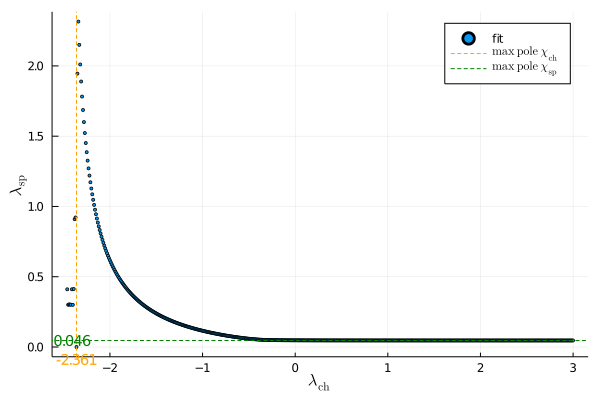

In [5]:
using LaTeXStrings
nh = ceil(Int64, size(rχsp,1)/2)
χsp_min    = -minimum(1 ./ rχsp[nh,:])
χch_min    = -minimum(1 ./ rχch[nh,:])
#plot(λch_range,spOfch_max_nl[1,:], label="naive", seriestype=:scatter, markersize=1.8)
#xticks = round.(union(λch_range[1]:((λch_range[end]-λch_range[1])/8):λch_range[end],[χch_min]), digits=2)
plot(λch_range,spOfch_max_nl[2,:], label="fit", xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\lambda_\mathrm{sp}", seriestype=:scatter, markersize=1.8)
plot!([χch_min], seriestype = :vline, linestyle=:dash, label=L"\mathrm{max\;pole\;}\chi_\mathrm{ch}", color=:orange)
annotate!([χch_min], -0.15, text("$(round(χch_min,digits=3))", 10, :bottom, color=:orange))
plot!([χsp_min], seriestype = :hline, linestyle=:dash, label=L"\mathrm{max\;pole\;}\chi_\mathrm{sp}", color=:green)
annotate!(χch_min - extra_ch - 0.14, [χsp_min], text("$(round(χsp_min,digits=3))", 10, :left, color=:green))
#savefig("cond1_b25U1.pdf")

# cond2 Test1

In [6]:
λch_range,spOfch_max_nl[2,:]
test1_overview_t1 = Array{Float64,2}(undef, length(λch_range),2);

testf_c2(λspi , λchi) = LadderDGA.calc_E_pot_cond(λspi , λchi, nlQ_sp, nlQ_ch, bubble, 
                         LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                         LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                         LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                         mP, sP, sP.tail_corrected);
for i in (1:length(λch_range))
    Σ_ladder2, lhs, E_pot = testf_c2(spOfch_max_nl[2,i], λch_range[i]) 
        #lhs, E_pot = cond_Epot_overview3(spOfch_max_nl[2,i], λch_range[i], nlQ_sp, nlQ_ch)
        test1_overview_t1[i,1] = lhs
        test1_overview_t1[i,2] = E_pot
        print("\r$(rpad(i,4)) of $(length(λch_range))")   
end

547  of 547

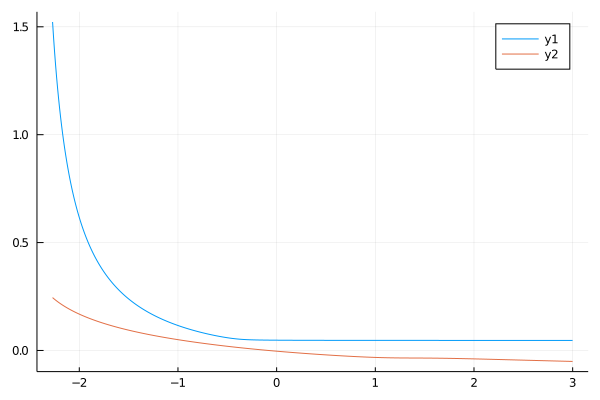

In [12]:
plot(λch_range[20:end],spOfch_max_nl[2,20:end])
plot!(λch_range[20:end], test1_overview_t1[20:end,1] - test1_overview_t1[20:end,2])

## compute λsp(λch) (Roots) - Deprecated

In [72]:
include("src/IO.jl")

writeFortranEnergies (generic function with 2 methods)

In [75]:
size(nlQ_sp.χ)

(161, 120)

In [74]:
writeFortranχ("testchi", nlQ_sp.χ, rχsp, LadderDGA.qGrid, usable_ω)

In [7]:
Xsp = @interval(0.07,0.1)
Xch = @interval(-2,2)
λch_range_c1 = -3.0:0.1:1.0
λch_range2_c1 = -15:1.0:15
spOfch_max_int_c1 = zeros(4,size(λch_range_c1)...)
spOfch_max_int_c1 = zeros(4,size(λch_range_c1)...)
spOfch2_max_int_c1 = zeros(4,size(λch_range2_c1)...)
spOfch3_max_int_c1 = zeros(4,size(λch_range2_c1)...);

In [78]:
for (mi,m) in enumerate([:naive, :fit])
    println("\rmode: ", m)
    rhs_val = (m == :fit || m == :both) ? (mP.n) * (1 - mP.n/2) : real(impQ_sp.χ_loc + impQ_ch.χ_loc)
    for (λi,λchi) in enumerate(λch_range_c1)
        ff(x) = testf(x,λchi,m)
        fdf(x) = testdf(x,λchi,m)
        print("\r", λi, " of ", length(λch_range_c1))
        res_internal = roots(ff, fdf, Xsp, Newton, 1e-6)
        max_int = maximum(interval.(res_internal))
        spOfch_max_int_c1[mi,λi] = mid(max_int)
    end
end
#for (mi,m) in enumerate([:naive, :sub, :fit, :both])
#    println("\rmode: ", m)
#    for (λi,λchi) in enumerate(λch_range2_c1)
#        testf(λsp) = construct_f(λsp, λchi, rχsp, rχch, mode=m, rhs=rhs_val)
#        res_internal = roots(testf, testdf, Xsp, Newton, 1e-5)
#        max_int = maximum(interval.(res_internal))
#        spOfch2_max_int_c1[mi,λi] = mid(max_int)
#        print("\r", rpad(λi,length(string(length(λch_range2_c1)))), " of ", length(λch_range2_c1))
#    end
#end

#for (λi,λchi) in enumerate(λch_range2_c1)
#    testf(λsp) = construct_f(λsp, λchi, rχsp, rχch, qMultiplicity, rhs=rhs)
#    res_internal = roots(testf, Xsp, Newton, 1e-5)
#    max_int = maximum(interval.(res_internal))
#    spOfch3_max_int_c1[λi] = mid(max_int)
#    print("\r", λi, " of ", length(λch_range2_c1))
#end

mode: naive
mode: 41fit
41 of 41

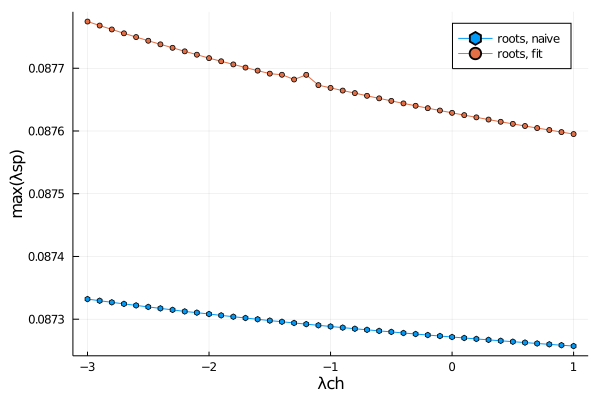

In [15]:
plot(λch_range_c1[1:end], spOfch_max_int_c1[1,1:end], label="roots, naive", xlabel="λch", ylabel="max(λsp)", xticks = λch_range_c1[1:10:end], markershape=:hexagon, markersize=2.8)
plot!(λch_range_c1[1:end], spOfch_max_int_c1[2,1:end], label="roots, fit", xlabel="λch", ylabel="max(λsp)", xticks = λch_range_c1[1:10:end], markershape=:circle, markersize=2.8)
#plot!(λch_range2_c1[10:end], spOfch2_max_int_c1[3,10:end], label="roots, fit", xlabel="λch", ylabel="max(λsp)", xticks = λch_range2_c1[1:10:end],seriestype = :scatter, markersize=2.8)
#plot!(λch_range2_c1[10:end], spOfch2_max_int_c1[4,10:end], label="roots, both", xlabel="λch", ylabel="max(λsp)", xticks = λch_range2_c1[1:10:end],seriestype = :scatter, markersize=2.8)
#savefig("roots_tc_EoMtc.pdf")
#plot!(λch_range, spOfch_max_nl, label="NLsolve", seriestype = :scatter, markersize=0.8)

In [22]:
#using JLD
#save("cond_1_data_b25u1_large_2.jld", "λch_range_c1", λch_range_c1, "spOfch_max_int_c1", spOfch_max_int_c1, "λch_range2_c1", λch_range2_c1, "spOfch2_max_int_c1", spOfch2_max_int_c1)

# Write to csv

In [26]:
#λch_r = λch_range_c2
#λsp_r = λsp_range_c2
#lhs_arr = lhs_overview
#rhs_arr = rhs_overview
function write_cond1(fn, λch_r, λsp_r)
open(fn, "w") do f
    @printf(f, "         lambda_ch             max(lambda_sp)\n")
    for i in (1:length(λch_r))
        for j in 1:length(λsp_r)
            @printf(f, "  %18.10f  %18.10f\n",
                λch_r[i], λsp_r[j])
        end
    end
end
end
function write_cond2(fn, λch_r, λsp_r, lhs_arr, rhs_arr)
open(fn, "w") do f
    @printf(f, "         lambda_ch             lambda_sp         sum_chi_m            G Sigma\n")
    for i in (1:length(λch_r))
        for j in 1:length(λsp_r)
            lhs = lhs_arr[i,j]
            E_pot = rhs_arr[i,j] 
            @printf(f, "  %18.10f  %18.10f  %18.10f  %18.10f\n",
                λch_r[i], λsp_r[j],
                Float64(lhs, RoundDown), Float64(E_pot, RoundDown))
        end
    end
end
end

function write_cond2_as_f_c1(fn, λch_r, λsp_r, lhs_arr, rhs_arr)
open(fn, "w") do f
    @printf(f, "         lambda_ch             lambda_sp         sum_chi_m            G Sigma\n")
    for i in (1:length(λch_r))
        lhs = lhs_arr[i]
        E_pot = rhs_arr[i] 
        @printf(f, "  %18.10f  %18.10f  %18.10f  %18.10f\n",
            λch_r[i], λsp_r[i],
            Float64(lhs, RoundDown), Float64(E_pot, RoundDown))
    end
end
end

write_cond2_as_f_c1 (generic function with 1 method)

In [19]:
write_cond1("c1_U1_b25.csv",λch_range,spOfch_max_nl[2,:])

In [27]:
write_cond2_as_f_c1("c2_as_f_of_1_U1_b25.csv",λch_range,spOfch_max_nl[2,:], test1_overview_t1[:,1], test1_overview_t1[:,2])

# Condition 2

In [14]:
modelParams

Main.LadderDGA.ModelParameters(1.0, 0.5, 25.0, 1.0, 3)

In [16]:
cond_Epot_overview3(λsp, λch, nlQ_sp, nlQ_ch) = LadderDGA.calc_E_pot_cond(λsp, λch, nlQ_sp, nlQ_ch, bubble, 
                         LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                         LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                         LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                         mP, sP, sP.tail_corrected);

In [46]:
λch_range_c22 = -0.086:0.0001:-0.082
λsp_range_c22 = 0.047:0.00002:0.049
length(λch_range_c2)*length(λsp_range_c2)

2501

In [93]:
rhs_overview2 = Array{Float64,2}(undef, length(λch_range_c22),length(λsp_range_c22));
lhs_overview2 = Array{Float64,2}(undef, length(λch_range_c22),length(λsp_range_c22));

for i in (1:length(λch_range_c22))
    λch_i = λch_range_c22[i]
    for (j,λsp_i) in enumerate(λsp_range_c22)
        _, lhs, E_pot = cond_Epot_overview3(λsp_i, λch_i, nlQ_sp, nlQ_ch)
        lhs_overview2[i,j] = lhs
        rhs_overview2[i,j] = E_pot
        print("\r", rpad(i,3), " ", rpad(j,3), " = ", rpad((i-1)*length(λsp_range_c22) + j,4)," of ", length(λch_range_c22)*length(λsp_range_c22))   
    end
end

5   42 

9   83  = 891 

14  23  = 1336 of 4141

18  65 

23  5   = 2227

27  46  = 2672 of 4141

31  88 

36  28  = 3563

40  69  = 4008 of 4141

41  101 = 4141 of 4141

-0.30973273023137976


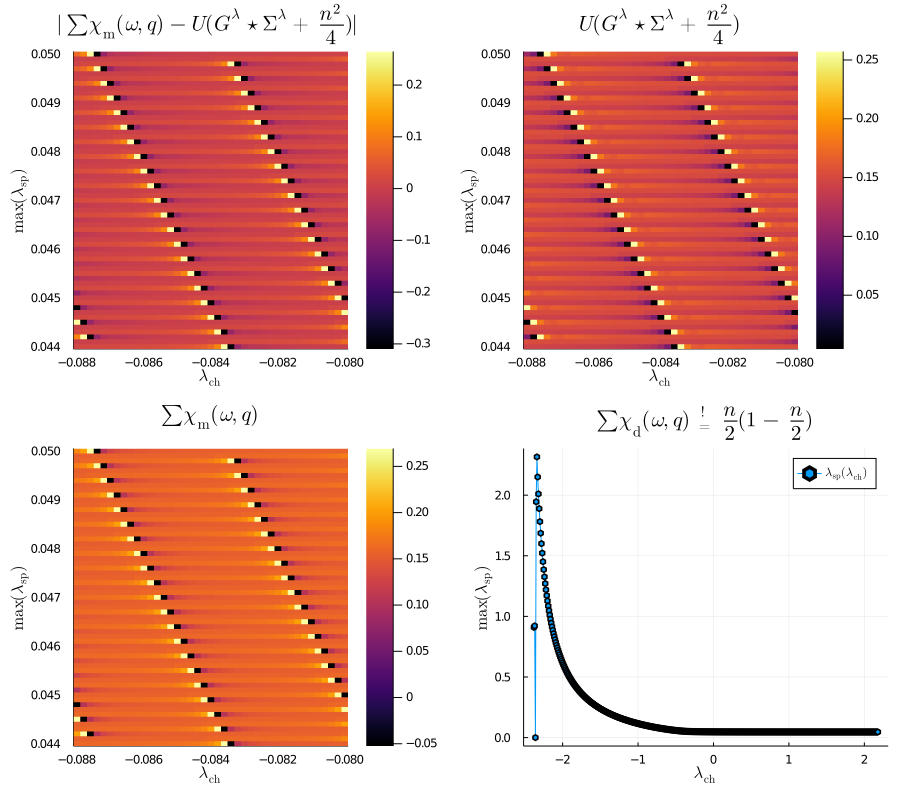

In [101]:
println(minimum((lhs_overview .- rhs_overview)))
writedlm("cond2_lhs.csv",  lhs_overview , ' ')
writedlm("cond2_rhs.csv",  rhs_overview , ' ')
plot(heatmap(λch_range_c2, λsp_range_c2, (lhs_overview .- rhs_overview), xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", title=L"|\sum \chi_\mathrm{m}(\omega,q) -  U (G^\lambda \star \Sigma^\lambda + \frac{n^2}{4})|"), 
    heatmap(λch_range_c2, λsp_range_c2, rhs_overview, xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", title=L"U (G^\lambda \star \Sigma^\lambda + \frac{n^2}{4})"), 
    heatmap(λch_range_c2, λsp_range_c2, lhs_overview, xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", title=L"\sum \chi_\mathrm{m}(\omega,q)"),
    plot(λch_range[9:end-82], spOfch_max_nl[2,9:end-82], title=L"\sum \chi_\mathrm{d}(\omega, q) \stackrel{!}{=} \frac{n}{2} (1 - \frac{n}{2})", label=L"\lambda_\mathrm{sp}(\lambda_\mathrm{ch})", xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", markershape=:hexagon, markersize=2.8),
    layout=(2,2),size=(900,800))


0.30630548501926147


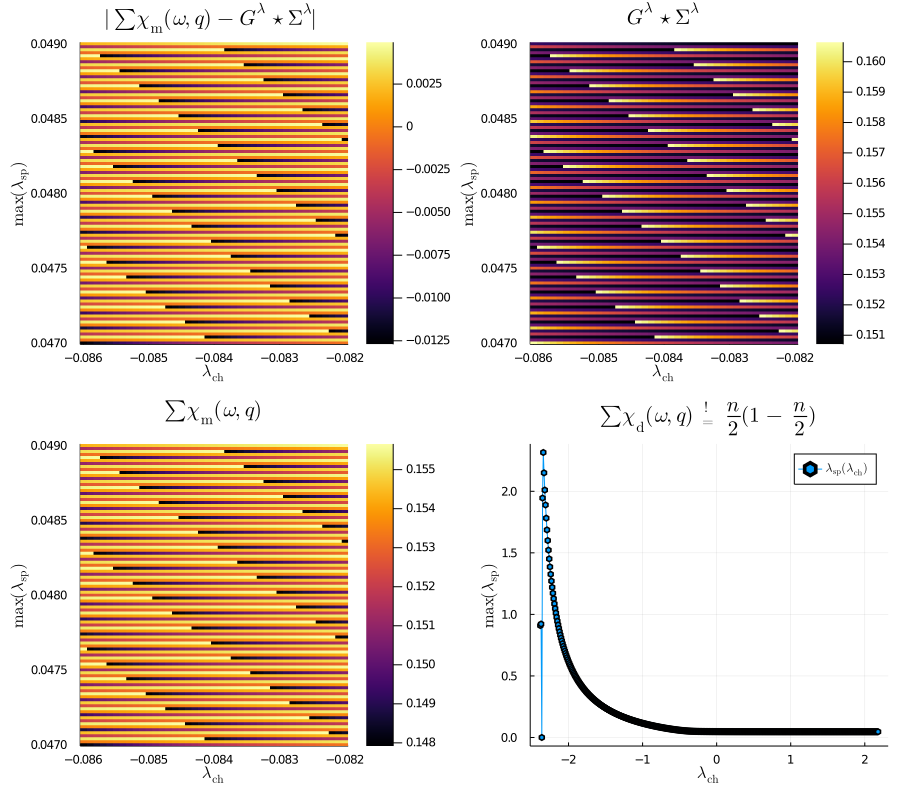

In [98]:
println(minimum((lhs_overview2 .+ rhs_overview2)))
writedlm("cond2_lhs2.csv",  lhs_overview2, ' ')
writedlm("cond2_rhs2.csv",  rhs_overview2, ' ')
plot(heatmap(λch_range_c22, λsp_range_c22, (lhs_overview2 .- rhs_overview2), xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", title=L"|\sum \chi_\mathrm{m}(\omega,q) - G^\lambda \star \Sigma^\lambda|"), 
    heatmap(λch_range_c22, λsp_range_c22, rhs_overview2, xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", title=L"G^\lambda \star \Sigma^\lambda"), 
    heatmap(λch_range_c22, λsp_range_c22, lhs_overview2, xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", title=L"\sum \chi_\mathrm{m}(\omega,q)"),
    plot(λch_range[9:end-82], spOfch_max_nl[2,9:end-82], title=L"\sum \chi_\mathrm{d}(\omega, q) \stackrel{!}{=} \frac{n}{2} (1 - \frac{n}{2})", label=L"\lambda_\mathrm{sp}(\lambda_\mathrm{ch})", xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", markershape=:hexagon, markersize=2.8),
    layout=(2,2),size=(900,800))


In [72]:
savefig("cond2_testb25u1.pdf")
#save("rhs_lhs_tc_EoMtc_b25u1_overview_2.jld", "lhs", lhs_overview, "rhs", rhs_overview, "λch_range_c2", λch_range_c2, "λsp_range_c2", λsp_range_c2)

# Both conditions

In [123]:
mP = LadderDGA.modelParams
sP = LadderDGA.simParams
nc = [0,1,2,3]
NW = floor(Int64, length(usable_ω)/2)
ωmin = 1
ωmax = NW 
coeffs = collect(0:3)
Wω = LadderDGA.build_weights(ωmin, ωmax, coeffs)
println("building  weight matrix from $ωmin to $ωmax with coefficients $(coeffs)")
include("src/ConvergenceAcc.jl")
#Shanks.shanks(E_Pot, csum_inp=true) 

testf_c2(λspi , λchi) = LadderDGA.calc_E_pot_cond(λspi , λchi, nlQ_sp, nlQ_ch, bubble, 
                         LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                         LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                         LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                         mP, sP, sP.tail_corrected);
function cond_both_nc!(F, λ)
    testf!(λ) = construct_f(λ[1],λchi, rχsp, rχch, mode=m, rhs=rhs_val)
    testdf!(λ) = construct_df(λ[1], λchi, rχsp, rχch, mode=m, rhs=rhs_val);
    Σ_ladder2, lhs_c2, E_pot_DGA = testf_c2(λ[1], λ[2])
    χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ), λ[1])
    χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ), λ[2])
    χupup = LadderDGA.sum_q(χch_λ[usable_ω,:].+ χsp_λ[usable_ω,:], LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
    nwh = ceil(Int64, size(χsp_λ,1)/2)
    penalty = sum(abs.(χsp_λ[nwh,(χsp_λ[nwh,:] .< 0)])) + sum(abs.(χch_λ[nwh,(χch_λ[nwh,:] .< 0)])) 
    #penalty2 = length(χch_λ[nwh,((χch_λ[nwh,:] .< 0.01) .& (χch_λ[nwh,:] .>= 0.0))])
    tmp =  real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1]) 
    #tmp += -penalty
    lhs_c1 = (mP.n/2) * (1 - mP.n/2)
    println("calling for λ=$λ, E_pot=$(E_pot_DGA), penalty = $penalty")
    F[1] = penalty > 0 ? penalty : tmp - lhs_c1
    F[2] = (lhs_c2) - E_pot_DGA# - penalty
end

function cond_both_c!(F, λ)
    Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(λ[1], λ[2], nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=true);
    χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ), λ[1])
    χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ), λ[2])
    χupup = LadderDGA.sum_q(χch_λ[usable_ω,:].+ χsp_λ[usable_ω,:], LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
    nwh = ceil(Int64, size(χsp_λ,1)/2)
    penalty = sum(abs.(χsp_λ[nwh,(χsp_λ[nwh,:] .< 0)])) + sum(abs.(χch_λ[nwh,(χch_λ[nwh,:] .< 0)])) 
    #penalty2 = length(χch_λ[nwh,((χch_λ[nwh,:] .< 0.01) .& (χch_λ[nwh,:] .>= 0.0))])
    tmp =  real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1]) 
    #tmp += -penalty
    lhs_c1 = mP.n/2 * (1 - mP.n/2)
    println("calling for λ=$(round.(λ,digits=2)), E_pot=$(E_pot_DGA), res = $(abs(tmp - lhs_c1) + abs(E_pot_DGA + (lhs_c2))), penalty = $penalty")
    F[1] = penalty > 0 ? penalty : tmp - lhs_c1
    F[2] = (lhs_c2) - E_pot_DGA
end

building  weight matrix from 1 to 12 with coefficients [0, 1, 2, 3]


cond_both_c! (generic function with 1 method)

In [19]:
include("src/ConvergenceAcc.jl")
E_Kin, E_Pot = LadderDGA.calc_E(Σ_ladder2, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);
Wν = LadderDGA.build_weights(1, length(E_Pot), [0,1,2,3,4,5,6])
res_fs = LadderDGA.fit_νsum(Wν, E_Pot[1:end])
res_sh = Shanks.shanks(E_Pot, csum_inp=true)[1]
println("naive = $(E_Pot[end]), νfit = $(res_fs), shanks = $(res_sh)")

LoadError: UndefVarError: Σ_ladder2 not defined

In [128]:
res_nc = nlsolve(cond_both_nc!, init)

calling for λ=[0.048, -0.08], E_pot=0.1530667899570978, penalty = 0.0
calling for λ=[0.04800605545445239, -0.08], E_pot=0.15304540652485651, penalty = 0.0
calling for λ=[0.04799394454554761, -0.08], E_pot=0.1530883069383539, penalty = 0.0
calling for λ=[0.048, -0.0799939445455476], E_pot=0.153066767704966, penalty = 0.0
calling for λ=[0.048, -0.0800060554544524], E_pot=0.15306681220930948, penalty = 0.0
calling for λ=[0.04787086861112934, -0.08382124837082093], E_pot=0.15357098606293376, penalty = 0.0
calling for λ=[0.04787086861112934, -0.08382124837082093], E_pot=0.15357098606293376, penalty = 0.0
calling for λ=[0.04787692406558173, -0.08382124837082093], E_pot=0.15354643190817924, penalty = 0.0
calling for λ=[0.04786481315667695, -0.08382124837082093], E_pot=0.15359570722931018, penalty = 0.0
calling for λ=[0.04787086861112934, -0.08381519291636853], E_pot=0.1535709637532736, penalty = 0.0
calling for λ=[0.04787086861112934, -0.08382730382527333], E_pot=0.15357100837267415, penalty 

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.048, -0.08]
 * Zero: [0.04787907749748291, -0.08379495789274265]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4

In [124]:
init = [ 0.048; -0.08]
#res_nc = nlsolve(cond_both_nc!, init);
res_c = nlsolve(cond_both_c!, init);

calling for λ=[0.05, -0.08], E_pot=0.1531259842763013, res = 0.30734551698436485, penalty = 0.0
calling for λ=[0.05, -0.08], E_pot=0.15307792968080583, res = 0.3073293076385779, penalty = 0.0
calling for λ=[0.05, -0.08], E_pot=0.1531446989154058, res = 0.30733218140677215, penalty = 0.0
calling for λ=[0.05, -0.08], E_pot=0.15312599861624226, res = 0.3073455313243056, penalty = 0.0
calling for λ=[0.05, -0.08], E_pot=0.153117651215196, res = 0.3073371839232593, penalty = 0.0
calling for λ=[0.05, -0.08], E_pot=0.1536787188249321, res = 0.30713290088067213, penalty = 0.0
calling for λ=[0.05, -0.08], E_pot=0.1536787188249321, res = 0.30713290088067213, penalty = 0.0
calling for λ=[0.05, -0.08], E_pot=0.15365387402071073, res = 0.30710805607645075, penalty = 0.0
calling for λ=[0.05, -0.08], E_pot=0.15370359349383944, res = 0.30715777554957935, penalty = 0.0
calling for λ=[0.05, -0.08], E_pot=0.15367869853647564, res = 0.3071327182491021, penalty = 0.0
calling for λ=[0.05, -0.08], E_pot=0.153

In [163]:
using LaTeXStrings
χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ[usable_ω,:]), res_nc.zero[1])
χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ[usable_ω,:]), res_nc.zero[2])
χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
χupdo = LadderDGA.sum_q(χch_λ .- χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
rhs_c1 = real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1])  
rhs_c2 = mP.U * real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω)[1])  + mP.n^2/4
lhs_c1 = mP.n/2 * (1 - mP.n/2)
Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(res_nc.zero[1], res_nc.zero[2], nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=false);
E_Kin, E_Pot = LadderDGA.calc_E(Σ_ladder2, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);


l = @layout [A{0.01h}; 
             [grid(1,2)
              b{0.3h}]]
nhi = 20
xarr = usable_ω .- ceil(Int64, size(bubble,1)/2)
title = plot(title = L"U=%$(mP.U), \beta=%$(mP.β)", grid = false, showaxis = false, bottom_margin = -50Plots.px)
p1 = plot(xarr, χsp_λ[:,1], legend = true, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{sp}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, χsp_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, χsp_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:circle, markersize=2)
annotate_y_pos = 0.7*maximum([maximum(χsp_λ[:,1]), maximum(χsp_λ[:,nhi]), maximum(χsp_λ[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{sp} = %$(round(res_nc.zero[1],digits=3))", :right, 10))

    
p2 = plot(xarr, χch_λ[:,1], legend = false, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{ch}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, χch_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, χch_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:hexagon, markersize=2)
annotate_y_pos = 0.75*maximum([maximum(χch_λ[:,1]), maximum(χch_λ[:,nhi]), maximum(χch_λ[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{ch} = %$(round(res_nc.zero[2],digits=3))", :right, 10))


p3 = plot(E_Pot, xlabel=L"\nu_n", label=L"\qquad\qquad\;\;\; G^\lambda \star \Sigma^\lambda = %$(round(E_Pot[end], digits=6))", markershape=:hexagon, markersize=2,legend=:bottomright, legendfontsize=9)
plot!([rhs_c2], seriestype = :hline, label=L"\frac{1}{\beta N_k} \sum_{\omega,q} \chi_\mathrm{up, do}\quad\, = %$(round(rhs_c2, digits=6))")
plot!([E_Pot[end]], seriestype = :hline, linestyle=:dash, label=L"\mathrm{\;\;\;naive\;E}_\mathrm{pot, LDGA} = %$(round(E_pot_DGA, digits=6))")
annotate_y_pos = (0.3*(maximum(E_Pot) - minimum(E_Pot)) + minimum(E_Pot))
annotate!(0.2*length(E_Pot), annotate_y_pos, text(L"\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} = %$(round(rhs_c1,digits=14)) \stackrel{!}{=} \frac{n}{2} (1-\frac{n}{2}) = %$(mP.n/2 *(1 - mP.n/2))", :left, 10))

plot(title, p1, p2, p3, layout = l, size=(1000,800))
savefig("cond_solution_tc_test_b15U2.pdf")

In [233]:

function calc_E_notail(Σ, ϵqGrid, qM, Nk, mP, sP)
    #println("TODO: E_pot function has to be tested")
    #println("TODO: use GNew/GLoc/GImp instead of Sigma")
    #println("TODO: make frequency summation with sum_freq an optional")
    νGrid = 0:sP.n_iν-1
    iν_n = LadderDGA.iν_array(mP.β, νGrid)
    Σ_hartree = mP.n * mP.U/2
    Σ_corr = Σ .+ Σ_hartree

    norm = (mP.β * Nk^mP.D)
    E_kin_tail_c = [zeros(size(ϵqGrid))]
    E_pot_tail_c = [zeros(size(ϵqGrid))]
    tail = [1 ./ (iν_n .^ n) for n in 1:length(E_kin_tail_c)]
    E_pot_tail = sum(E_pot_tail_c[i]' .* tail[i] for i in 1:length(tail))
    E_kin_tail = sum(E_kin_tail_c[i]' .* tail[i] for i in 1:length(tail))
    E_pot_tail_inv = sum((mP.β/2)  .* [Σ_hartree .* ones(size(ϵqGrid))])
    E_kin_tail_inv = sum(map(x->x .* (mP.β/2) .* ϵqGrid , [1]))

    G_corr = flatten_2D(G_from_Σ(Σ_corr, ϵqGrid, νGrid, mP));
    E_pot = real.(G_corr .* Σ_corr .- E_pot_tail);
    E_kin = ϵqGrid' .* real.(G_corr .- E_kin_tail);

    E_pot = [sum( (2 .* sum(E_pot[1:i,:], dims=[1])[1,:] .+ E_pot_tail_inv) .* qM) / norm for i in 1:sP.n_iν]
    E_kin = [sum( (4 .* sum(E_kin[1:i,:], dims=[1])[1,:] .+ E_kin_tail_inv) .* qM) / norm for i in 1:sP.n_iν]

    return E_kin, E_pot
end


calc_E_notail (generic function with 1 method)

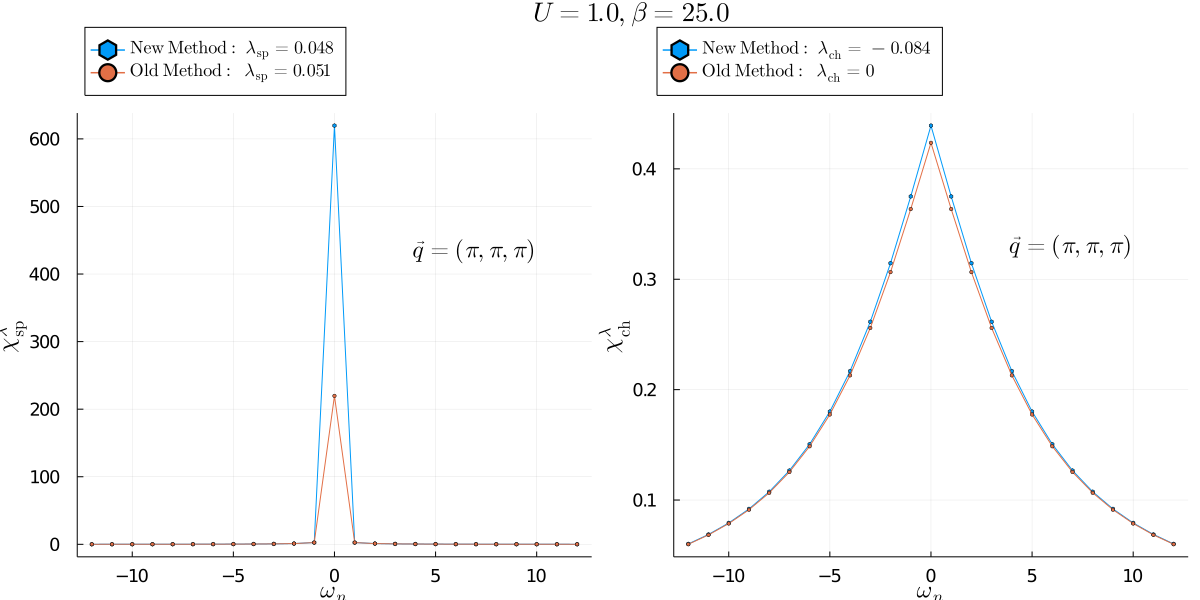

In [319]:
using LaTeXStrings

χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ[usable_ω,:]), res_nc.zero[1])
χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ[usable_ω,:]), res_nc.zero[2])
χsp_λ_old = LadderDGA.χ_λ(real.(nlQ_sp.χ[usable_ω,:]),0.050817859568877091)
χch_λ_old = LadderDGA.χ_λ(real.(nlQ_ch.χ[usable_ω,:]), 0.0)
χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
χupdo = LadderDGA.sum_q(χch_λ .- χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
rhs_c1 = real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1])  
rhs_c2 = mP.U * real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω)[1])  + mP.n^2/4
lhs_c1 = mP.n/2 * (1 - mP.n/2)
Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(res_nc.zero[1], res_nc.zero[2], nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=false);
E_Kin, E_Pot = LadderDGA.calc_E(Σ_ladder2, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);
E_Kin_naive, E_Pot_naive = calc_E_notail(Σ_ladder2, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);
l = @layout [A{0.025h}; 
             grid(1,2)]
nhi = 20
xarr = usable_ω .- ceil(Int64, size(bubble,1)/2)
title = plot(title = L"U=%$(mP.U), \beta=%$(mP.β)", grid = false, showaxis = false, bottom_margin = -50Plots.px, titlefontsize=18)
p1 = plot(xarr, χsp_λ[:,end], legend = :outertop, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{sp}}", label=L"\mathrm{New\;Method:}\; \lambda_\mathrm{sp} = %$(round(res_nc.zero[1],digits=3))", markershape=:hexagon, markerstrokewidth=0.4, markersize=2,xtickfontsize=12,ytickfontsize=12,legendfontsize=12,xguidefontsize=16,yguidefontsize=16)
plot!(xarr, χsp_λ_old[:,end], label=L"\mathrm{Old\;Method:}\;\; \lambda_\mathrm{sp} = 0.051", markershape=:circle, markersize=2, markerstrokewidth=0.4)
#plot!(xarr, χsp_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:circle, markersize=2)
#p1 = plot(xarr, χsp_λ[:,end], label=L"q=$(\pi,\pi,\pi)", markershape=:circle, markersize=2)
annotate_y_pos = 0.7*maximum([maximum(χsp_λ[:,1]), maximum(χsp_λ[:,nhi]), maximum(χsp_λ[:,end])])
#annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{sp} = %$(round(res_nc.zero[1],digits=3))", :right, 10))
annotate!(xarr[end-2], annotate_y_pos, text(L"\vec{q}=(\pi,\pi,\pi)", :right, 16))
    
p2 = plot(xarr, χch_λ[:,end], legend = :outertop, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{ch}}", label=L"\mathrm{New\;Method:}\; \lambda_\mathrm{ch} = %$(round(res_nc.zero[2],digits=3))", markershape=:hexagon, markersize=2, markerstrokewidth=0.4,xtickfontsize=12,ytickfontsize=12,legendfontsize=12,xguidefontsize=16,yguidefontsize=16)
plot!(xarr, χch_λ_old[:,end], label=L"\mathrm{Old\;Method:}\;\; \lambda_\mathrm{ch} = 0", markershape=:circle, markersize=2, markerstrokewidth=0.4)
#plot!(xarr, χch_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:hexagon, markersize=2)
#plot!(xarr, χch_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:hexagon, markersize=2)
annotate_y_pos = 0.75*maximum([maximum(χch_λ[:,1]), maximum(χch_λ[:,nhi]), maximum(χch_λ[:,end])])
#annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{ch} = %$(round(res_nc.zero[2],digits=3))", :right, 10))
annotate!(xarr[end-2], annotate_y_pos, text(L"\vec{q}=(\pi,\pi,\pi)", :right, 16))



plot(title, p1, p2, layout = l, size=(1200,600))
#savefig("cond_solution_tc_test_b25U1.pdf")

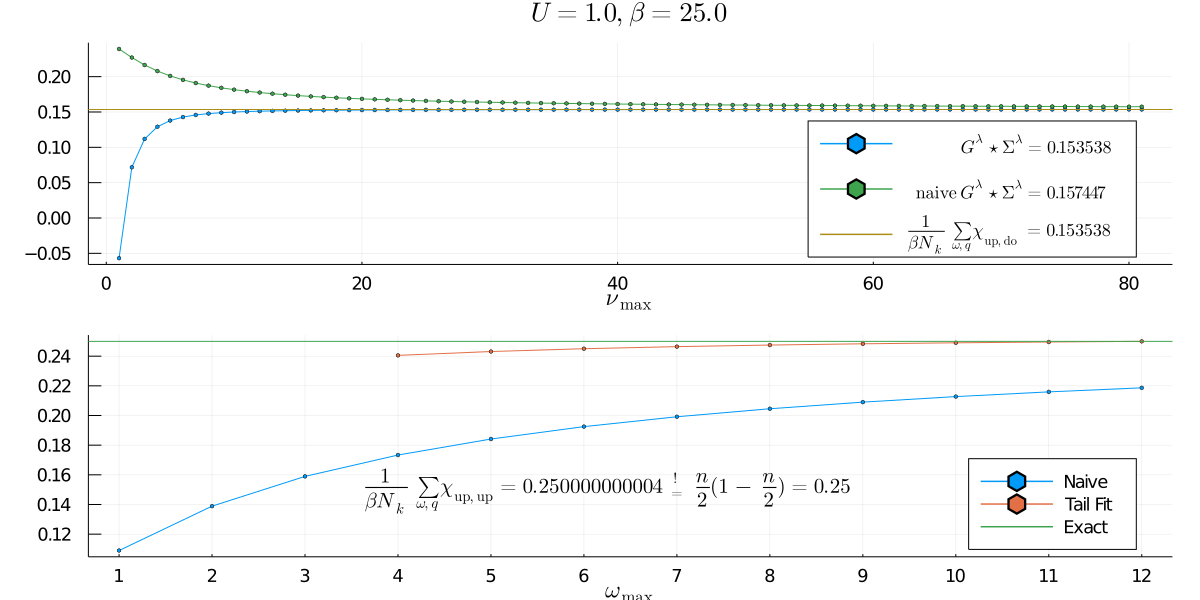

In [380]:
l2 = @layout [A{0.025h}; 
             grid(2,1)]
nanline = repeat([NaN], length(E_Pot))
p3 = plot([E_Pot], xlabel=L"\nu_\mathrm{max}", 
    label=L"{\;\;\;\qquad\quad\, G^\lambda \star \Sigma^\lambda = %$(round(E_Pot[end], digits=6))}" ,
    markershape=:hexagon, markersize=2, markerstrokewidth=0.4,legend=:bottomright, margin=5Plots.mm,
    xtickfontsize=12,ytickfontsize=12, legendfontsize=12,xguidefontsize=16,yguidefontsize=16)
plot!(nanline, label=" ", alpha= 0.0)
plot!(E_Pot_naive, markershape=:hexagon, markersize=2, markerstrokewidth=0.4, label=L"{\;\;\;\mathrm{naive}\;G^\lambda \star \Sigma^\lambda = %$(round(E_Pot_naive[end], digits=6))}")
plot!(nanline, label=" ", alpha= 0.0)
plot!([rhs_c2], seriestype = :hline, label=L"\frac{1}{\beta N_k} \sum_{\omega,q} \chi_\mathrm{up, do}\; = %$(round(rhs_c2, digits=6))")
tt = [real(LadderDGA.sum_freq(χupup[i+1:(end-i)], [1], true, mP.β, weights=LadderDGA.build_weights(1, floor(Int64, size(χupup[i+1:(end-i)], 1)/2), collect(0:3)))[1]) for i in 8:-1:0]
real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1]) 
p4 = plot(1:nh-1,(χupup[nh] .+ 2 .* cumsum(χupup[nh+1:end])) ./ mP.β, xlabel=L"\omega_\mathrm{max}", 
    label="Naive", xticks=collect(1:nh-1),
    markershape=:hexagon, markersize=2, markerstrokewidth=0.4,legend=:bottomright,xtickfontsize=12,ytickfontsize=12, legendfontsize=12,xguidefontsize=16,yguidefontsize=16)
plot!(nh-9:nh-1,tt,markershape=:hexagon, markersize=2, markerstrokewidth=0.4, label="Tail Fit")
plot!([0.25],  seriestype = :hline, label="Exact")
annotate_y_pos = (0.08*(maximum(χupup) - minimum(χupup)) + minimum(χupup))
annotate!(0.3*length(1:nh-1), annotate_y_pos, text(L"\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} = %$(round(rhs_c1,digits=12)) \stackrel{!}{=} \frac{n}{2} (1-\frac{n}{2}) = %$(mP.n/2 *(1 - mP.n/2))", :left, 14))

plot(title, p3, p4, layout = l2, size=(1200,600))
#savefig("cond_solution_tc_test_b25U1_2.pdf")

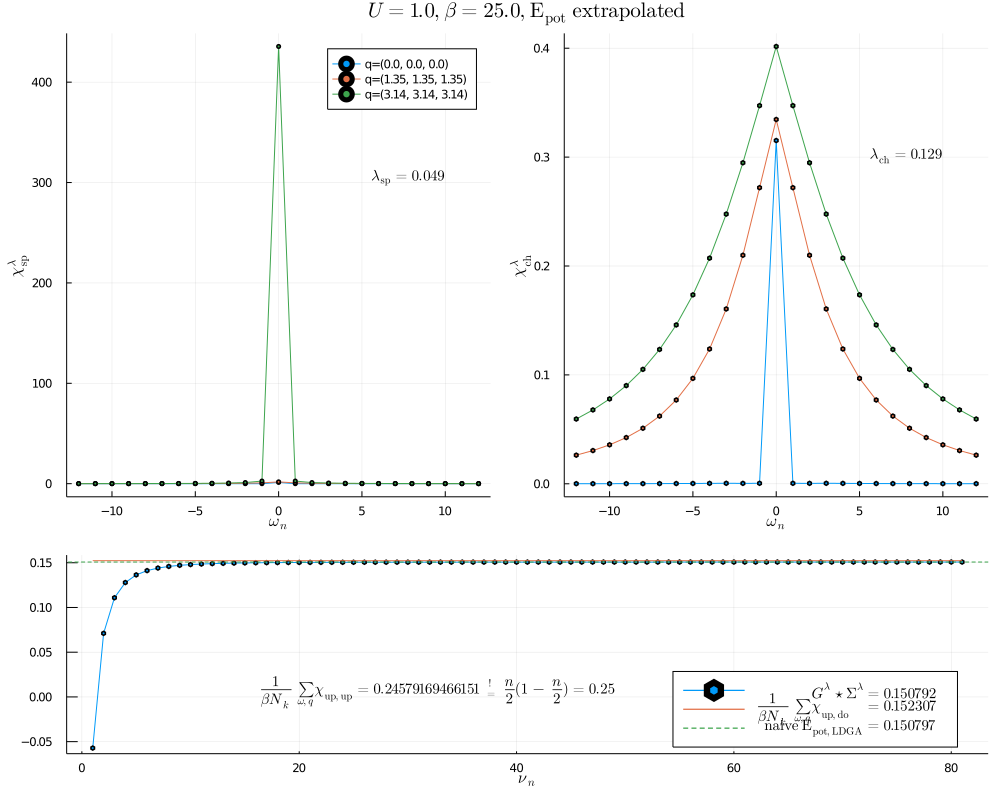

In [127]:
using LaTeXStrings
lsp_zero = 0.04856121321074435#res_c.zero[1]
lch_zero = 0.1292099471786603#res_c.zero[2]
χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ[usable_ω,:]), lsp_zero)
χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ[usable_ω,:]), lch_zero)
χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
χupdo = LadderDGA.sum_q(χch_λ .- χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
rhs_c1 = real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1])  
rhs_c2 = mP.U * real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω)[1])  + mP.n^2/4
lhs_c1 = (mP.n/2) * (1 - mP.n/2)
Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(lsp_zero, lch_zero, nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=true);
E_Kin, E_Pot = LadderDGA.calc_E(Σ_ladder2, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);

l = @layout [A{0.01h}; 
             [grid(1,2)
              b{0.3h}]]
nhi = 20
xarr = usable_ω .- ceil(Int64, size(bubble,1)/2)
title = plot(title = L"U=%$(mP.U), \beta=%$(mP.β), \mathrm{E}_\mathrm{pot} \mathrm{\;extrapolated}", grid = false, showaxis = false, bottom_margin = -50Plots.px)
p1 = plot(xarr, χsp_λ[:,1], legend = true, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{sp}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, χsp_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, χsp_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:circle, markersize=2)
annotate_y_pos = 0.7*maximum([maximum(χsp_λ[:,1]), maximum(χsp_λ[:,nhi]), maximum(χsp_λ[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{sp} = %$(round(lsp_zero,digits=3))", :right, 10))
    
p2 = plot(xarr, χch_λ[:,1], legend = false, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{ch}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, χch_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, χch_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:hexagon, markersize=2)
annotate_y_pos = 0.75*maximum([maximum(χch_λ[:,1]), maximum(χch_λ[:,nhi]), maximum(χch_λ[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{ch} = %$(round(lch_zero,digits=3))", :right, 10))


p3 = plot(E_Pot, xlabel=L"\nu_n", label=L"\qquad\qquad\;\;\; G^\lambda \star \Sigma^\lambda = %$(round(E_Pot[end], digits=6))", markershape=:hexagon, markersize=2,legend=:bottomright, legendfontsize=10)
plot!(repeat([rhs_c2], length(E_Pot)), label=L"\frac{1}{\beta N_k} \sum_{\omega,q} \chi_\mathrm{up, do}\quad\, = %$(round(rhs_c2, digits=6))")
#plot!([E_pot_DGA[1]], seriestype = :hline, linestyle=:dash, label=L"\qquad\qquad\mathrm{E}_\mathrm{pot, LDGA} = %$(round(E_pot_DGA[1], digits=6))")
plot!([E_Pot[end]], seriestype = :hline, linestyle=:dash, label=L"\mathrm{\;\;\;naive\;E}_\mathrm{pot, LDGA} = %$(round(E_pot_DGA[1], digits=6))")
annotate_y_pos = (0.3*(maximum(E_Pot) - minimum(E_Pot)) + minimum(E_Pot))
annotate!(0.2*length(E_Pot), annotate_y_pos, text(L"\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} = %$(round(rhs_c1,digits=14)) \stackrel{!}{=} \frac{n}{2} (1-\frac{n}{2}) = %$(mP.n/2 *(1 - mP.n/2))", :left, 10))

plot(title, p1, p2, p3, layout = l, size=(1000,800))
savefig("cond_solution_tc_test_b25U1.pdf")

In [414]:
ωmin2 = 1#Int(floor(last(usable_ω .- sP.n_iω)*3/4))
ωmax2 = Int(last(usable_ω) - sP.n_iω) - 1
Wω_1 = LadderDGA.build_weights(ωmin2, ωmax2, [0,1,2,3])
Wω_2 = LadderDGA.build_weights(ωmin2, ωmax2, [0,1,2,3,4])
Wω_3 = LadderDGA.build_weights(ωmin2, ωmax2, [0,1,2,3,4,5])
Wω_4 = LadderDGA.build_weights(ωmin2, ωmax2, [0,2,4,6])
χupdo_naive = mP.U .* (χupdo[13] + 2 * sum(χupdo[14:end])) ./ mP.β
χupdo_shanks = mP.U .* (χupdo[13] + 2 * Shanks.shanks(χupdo[14:end])[1]) ./ mP.β
χupdo_richardson = mP.U .* (χupdo[13] + 2 * Float64(Shanks.richardson(χupdo[14:end])[end-1])) ./ mP.β
χupdo_GFFit_1 = mP.U * (real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω_1)[1]))
χupdo_GFFit_2 = mP.U * (real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω_2)[1]))
χupdo_GFFit_3 = mP.U * (real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω_3)[1]))
χupdo_GFFit_4 = mP.U * (real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω_4)[1]))

println("""Naive = $χupdo_naive
Shanks = $χupdo_shanks
Richardson = $χupdo_richardson
GFFit(1:12,0:3) = $(χupdo_GFFit_1)
GFFit(1:12,0:4) = $(χupdo_GFFit_2)
GFFit(1:12,0:5) = $(χupdo_GFFit_3)
GFFit(1:12,[0,2,4,6]) = $(χupdo_GFFit_4)""")

Naive = -0.13491564533599373
Shanks = -0.13536593874628322
Richardson = -0.1350100865612612
GFFit(1:12,0:3) = -0.13714815359721577
GFFit(1:12,0:4) = -0.13525023028434366
GFFit(1:12,0:5) = -0.1347350940001175
GFFit(1:12,[0,2,4,6]) = -0.13580764633303455


# q-dependent correction

## Fit and subtract old $\frac{1}{i\omega^2}$ tail

In [103]:
G_from_Σ = LadderDGA.G_from_Σ
flatten_2D = LadderDGA.flatten_2D
ϵkGrid = LadderDGA.ϵkGrid
qGrid = LadderDGA.qGrid
kGrid = LadderDGA.kGrid
squareLattice_ekGrid = LadderDGA.squareLattice_ekGrid
Σ_corr = Σ_ladder
νGrid = 0:sP.n_iν-1;

In [107]:
using LsqFit
tail_func_real_tmp(iωn, c) = real.(c[1] ./(iωn .^ 2))

function cond3_tail(χ_r; min_ω=0)
    nh = ceil(Int64, size(χ_r,1)/2)
    iω_arr = LadderDGA.iω_array(mP.β, nh)[min_ω+1:end]
    p0 = [0.0]
    mapslices(ydata->curve_fit(tail_func_real_tmp, iω_arr, ydata, p0), χ_r[nh+min_ω:end,:], dims=[1])[1,:]
end

cond3_tail (generic function with 1 method)

2744

In [113]:
function calc_Ek_q(Σ, qGrid, ϵkGrid, kGrid, mP)
    res = zeros(size(qGrid))
    Σ_hartree = mP.n * mP.U/2
    Σ_corr = Σ .+ Σ_hartree
    G_corr = flatten_2D(G_from_Σ(Σ_corr, ϵqGrid, νGrid, mP));
    for qi in 1:length(qGrid)
        for νi in 1:size(G_corr, 1)
            G_tmp = LadderDGA.expand_kGrid(qIndices, G_corr[νi,:])
            ϵkpq = squareLattice_ekGrid(map(x-> x .+ LadderDGA.qGrid[qi], LadderDGA.kGrid))
            ϵkmq = squareLattice_ekGrid(map(x-> x .- LadderDGA.qGrid[qi], LadderDGA.kGrid))
            res[qi] += real(sum((ϵkpq .+ ϵkmq .- 2 .* ϵkGrid) .* G_tmp))
        end
    end
    #LadderDGA.calc_E(Σ_ladder2, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);
    return 2*res/(mP.β*prod(size(kGrid)))
end

calc_Ek_q (generic function with 1 method)

In [115]:
Ekinq = calc_Ek_q(Σ_ladder, qGrid, ϵkGrid, kGrid, mP)

120-element Array{Float64,1}:
 0.0
 0.011350466497078738
 0.02270093299415748
 0.03405139949123622
 0.04315376689423222
 0.054504233391310955
 0.06585469988838974
 0.08630753378846444
 0.09765800028554326
 0.12946130068269662
 0.08911086750592137
 0.10046133400300011
 0.11181180050007887
 ⋮
 0.5362209378789856
 0.587229471302214
 0.6331865719139035
 0.664989872311057
 0.45846053687014304
 0.4698110033672218
 0.5016143037643752
 0.5475714043760647
 0.5985799377992931
 0.644537038410982
 0.6763403388081356
 0.6876908053052139

In [116]:
sum(Ekinq)/

41.26144831831287

In [31]:
#ϵqGrid = reduce_kGrid(cut_mirror(collect(ϵkGrid)));
ϵqGrid = LadderDGA.ϵqGrid
qIndices = LadderDGA.qIndices
Σ_hartree = mP.n * mP.U/2
Σ_ladder_ω = SharedArray{Complex{Float64},3}(length(usable_ω), length(1:sP.n_iν), length(qIndices)) 
χsp_λq = SharedArray{Complex{Float64},2}(size(rχsp)...)
χch_λq = SharedArray{Complex{Float64},2}(size(rχch)...)
E_kin_tail_c = [zeros(size(ϵqGrid)), (ϵqGrid .+ Σ_hartree .- mP.μ)]
tail = [1 ./ (LadderDGA.iν_array(mP.β, 0:(sP.n_iν-1)) .^ n) for n in 1:length(E_kin_tail_c)]
E_kin_tail = sum(E_kin_tail_c[i]' .* tail[i] for i in 1:length(tail))
E_kin_tail_inv = sum(map(x->x .* (mP.β/2) .* ϵqGrid , [1, -(mP.β) .* E_kin_tail_c[2]]))
norm = (mP.β * sP.Nk^mP.D)

68600.0

In [32]:
E_kin_tail_inv

120-element Array{Float64,1}:
 -484.0593108923948
 -453.1175058323673
 -423.19728047281166
 -394.29863481372786
 -371.8618330653513
 -344.8040104186797
 -318.76776747247965
 -274.4310145408471
 -251.25717430753093
 -191.7668553188819
 -268.6125516202044
 -245.6910207364765
 -223.79106955322047
    ⋮
 -138.16322015875437
 -224.0182437008196
 -319.03886201176283
 -394.6001232070989
  -46.98022970253504
  -57.301396349833034
  -91.66200110101926
 -155.48308128188023
 -245.929042325009
 -345.08595239889615
 -423.50961630711606
 -453.44068910760507

In [121]:
E_Kin, E_Pot = LadderDGA.calc_E(Σ_ladder, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);
E_Kin

81-element Array{Float64,1}:
 -0.6947376136054546
 -0.4714531721141063
 -0.4075290626045404
 -0.3818730906468905
 -0.3696443469273653
 -0.3631459782265655
 -0.35940895458371785
 -0.35712269231072824
 -0.355651131219467
 -0.3546625965200382
 -0.3539739549140216
 -0.353479187830583
 -0.3531143357812143
  ⋮
 -0.3516669533462848
 -0.35166652392337866
 -0.3516661179440159
 -0.3516657338339662
 -0.35166537014445565
 -0.3516650255406386
 -0.35166469879125406
 -0.35166438875935524
 -0.35166409439396545
 -0.3516638147225711
 -0.3516635488443591
 -0.35166329592410617